arima_results.csv
dlinear_results.csv
gru_results.csv
informer_results.csv
nbeats_results.csv
transformer_results.csv


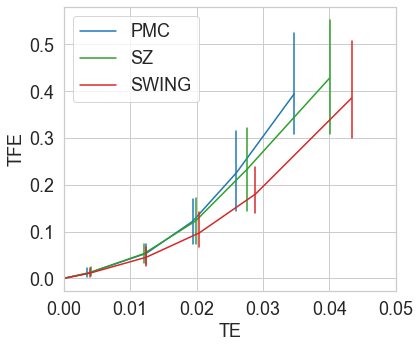

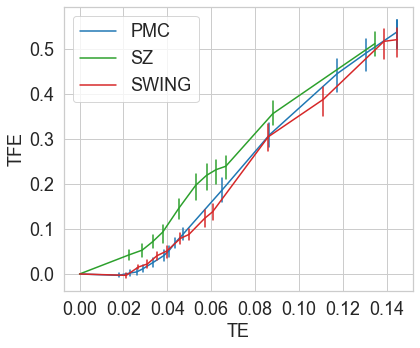

In [2]:
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['savefig.transparent'] = True
sns.set_theme(style="whitegrid")
palette = ['tab:blue', 'tab:green', 'tab:red']
hue_order = ['PMC', 'SZ', 'SWING']
sns.set(rc={"figure.figsize":(14, 6)})

def plot_te(df, dataset_name, metric='nrmse'):
    df = df[(df.data == dataset_name) & (df.metric == metric)]
    df.compression = df.compression.str.upper()
    sns.set(rc={"figure.figsize":(6, 4)})
    matplotlib.rcParams['axes.grid'] = True
    matplotlib.rcParams['savefig.transparent'] = True
    sns.set_theme(style="whitegrid")

    fig, ax1 = plt.subplots()
    # display(df)
    ax = sns.lineplot(data=df, x='eb', y='decompression error', hue='compression', hue_order=hue_order, palette=palette, ax=ax1)
    plt.legend(title='', fontsize='18')
    ax.set(xlabel='error bound', ylabel='transformation error NRMSE')

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        y = ax.get_ylabel()
        ax.set_xlabel(l, fontsize=18)
        ax.set_ylabel(y, fontsize=18)

    ax.set_xlim(0, 0.8)
    # ax.set_ylim(0, 0.23)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    plt.tight_layout()
    plt.savefig('../figures/aus_eb_de.pdf')


def plot_cr(df, dataset_name):
    df = df[(df.data == dataset_name)]
    df.compression = df.compression.str.upper()
    # df.gzip = np.log2(df.gzip.values)
    df.rename({'gzip': 'compression ratio'}, axis=1, inplace=True)
    sns.set(rc={"figure.figsize":(6, 4)})
    matplotlib.rcParams['axes.grid'] = True
    matplotlib.rcParams['savefig.transparent'] = True
    sns.set_theme(style="whitegrid")

    fig, ax1 = plt.subplots()

    ax = sns.lineplot(data=df, x='error_bound', y='compression ratio', hue='compression', hue_order=hue_order, palette=palette, ax=ax1)
    ax.axhline(np.log2(2.02), ls='--', c='black', label="GORILLA")
    # ax.annotate('raw data',(-0.5, 0),(10,10), textcoords = 'offset pixels')
    plt.yscale('log')
    plt.legend(title='', fontsize='18')
    # ax.set(xlabel='error bound')
    ax.set(xlabel='error bound', ylabel='compression ratio')

    #ax.set_xticklabels(ax.get_xticklabels(), rotation=0,  size=18)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        y = ax.get_ylabel()
        ax.set_xlabel(l, fontsize=18)
        ax.set_ylabel(y, fontsize=18)

    ax.set_xlim(0, 0.8)
    # ax.set_ylim(0, 35)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    plt.tight_layout()
    plt.savefig('../figures/aus_eb_cr.pdf')


def plot_compressed_data(data_name, data_dir, ot, ebs):
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    days = mdates.DayLocator()
    years_fmt = mdates.DateFormatter('%m-%d')

    subplot = 131
    for eblc in ['pmc', 'swing', 'sz']:
        if 'sz' in eblc:
            ebs = np.asarray(ebs)*0.01
        df = pd.read_parquet(data_dir%eblc)
        data_r = df[f'{ot}-R']
        data_pmc_eb0 = df[f'{ot}-E{ebs[0]}']
        data_pmc_eb1 = df[f'{ot}-E{ebs[1]}']

        sns.set(rc={"figure.figsize":(16, 5.5)})
        matplotlib.rcParams['axes.grid'] = True
        matplotlib.rcParams['savefig.transparent'] = True
        sns.set_theme(style="whitegrid")

        plt.subplot(subplot)
        sns.lineplot(data=data_r[:250], label='OR')
        sns.lineplot(data=data_pmc_eb0[:250], label='e=0.05')
        ax = sns.lineplot(data=data_pmc_eb1[:250], label='e=0.1')

        # ax.xaxis.set_major_locator(days)
        # ax.xaxis.set_major_formatter(years_fmt)
        # ax.xaxis.set_minor_locator(months)

        plt.legend(title='', fontsize='18', loc='lower left')

        ax.set(ylabel='values', xlabel=eblc.upper())

        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(18)

        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(18)

        subplot+=1

    plt.tight_layout()
    plt.savefig(f'../figures/{data_name}_compressed.pdf')


def get_tfe(model_results):
    baseline_result  = model_results[model_results.eblc == 'baseline']
    model_results['tfe'] = (model_results.nrmse.values - baseline_result.nrmse.values)/baseline_result.nrmse.values
    baseline_result = baseline_result.append([baseline_result]*2, ignore_index=True)
    baseline_result.at[0, 'eblc'] = 'pmc'
    baseline_result.at[1, 'eblc'] = 'sz'
    baseline_result.at[2, 'eblc'] = 'swing'
    baseline_result['tfe'] = 0.
    return pd.concat([model_results, baseline_result])

def plot_te_tfe_pweather():
    sns.set(rc={"figure.figsize":(6, 5)})
    matplotlib.rcParams['axes.grid'] = True
    matplotlib.rcParams['savefig.transparent'] = True
    sns.set_theme(style="whitegrid")
    pweather_results = pd.read_csv('../results/tfe/processed_weather.csv')
    pweather_results = pweather_results[pweather_results.te <= 0.15]
    ax = sns.lineplot(data=pweather_results,
                      x='te',
                      y='TFE',
                      hue='compression',
                      err_style='bars',
                      palette=palette,
                      hue_order=hue_order
                      )
    plt.legend(title='', fontsize='18', loc='upper left')

    ax.set(ylabel='TFE', xlabel='TE')

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        y = ax.get_ylabel()
        ax.set_xlabel(l, fontsize=18)
        ax.set_ylabel(y, fontsize=18)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    plt.tight_layout()
    plt.savefig(f'../figures/pweather_tfe_all.pdf')



def plot_te_tfe(data_name):
    sns.set(rc={"figure.figsize":(6, 5)})
    matplotlib.rcParams['axes.grid'] = True
    matplotlib.rcParams['savefig.transparent'] = True
    sns.set_theme(style="whitegrid")

    all_results = pd.DataFrame()
    for root, dirs, files in os.walk('../results/tfe/per_model/'):
        for result_file in files:
            print(result_file)
            if 'gru' in result_file or 'arima' in result_file:
                continue
            model_results = pd.read_csv(os.path.join(root, result_file))
            model_results = model_results[(model_results.data == data_name) & (model_results.error < 0.045)]
            model_results = get_tfe(model_results)
            all_results = pd.concat([all_results, model_results])


    all_results.reset_index(drop=True, inplace=True)
    all_results.eblc = all_results.eblc.str.upper()
    ax = sns.lineplot(data=all_results,
                      x='error',
                      y='tfe',
                      hue='eblc',
                      err_style='bars',
                      palette=palette,
                      hue_order=hue_order
                      )

    plt.legend(title='', fontsize='18', loc='upper left')

    ax.set(ylabel='TFE', xlabel='TE')

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    for ax in plt.gcf().axes:
        l = ax.get_xlabel()
        y = ax.get_ylabel()
        ax.set_xlabel(l, fontsize=18)
        ax.set_ylabel(y, fontsize=18)

    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)

    ax.set_xlim(0, 0.05)
    plt.tight_layout()
    plt.savefig(f'../figures/nogru_{data_name}_tfe_all.pdf')
    plt.show()

plot_te_tfe('aus')
plot_te_tfe_pweather()

D:\Anaconda\envs\dart\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
D:\Anaconda\envs\dart\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
D:\Anaconda\envs\dart\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

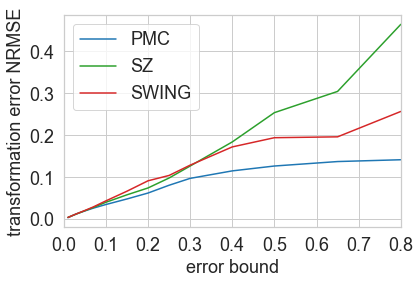

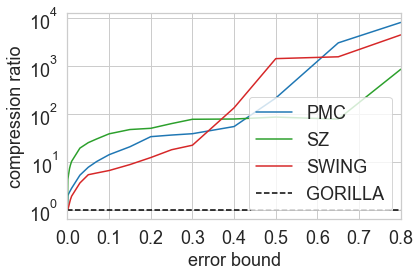

In [13]:
df = pd.read_csv('../results/te/transformation_error.csv')
plot_te(df, 'aus')
df = pd.read_csv('../results/cr/all_cr.csv')
plot_cr(df, 'aus')

D:\Anaconda\envs\dart\lib\site-packages\ipykernel_launcher.py:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later


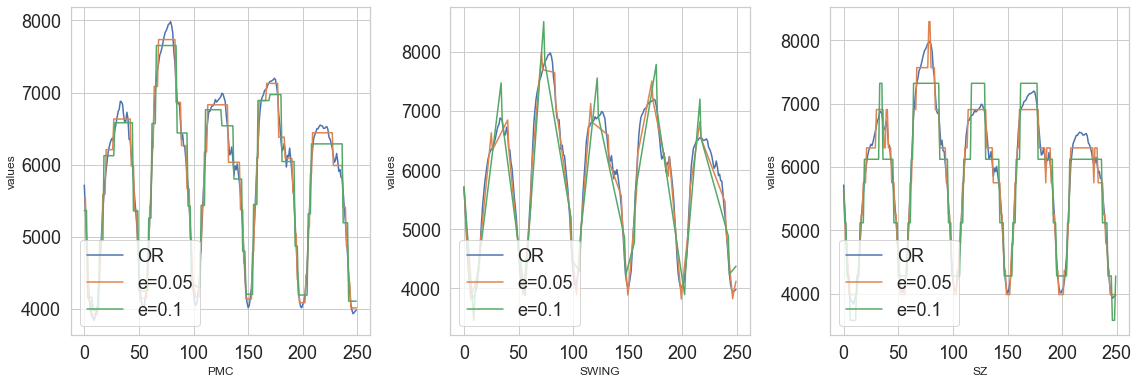

In [7]:
plot_compressed_data('aus', '../data/compressed/%s/aus_electrical_demand_points.parquet', 'y', (5.0, 10.0))